In [2]:
import torch
import torch.nn as nn
import nltk
from nltk.stem.porter import PorterStemmer
from collections import Counter
import json
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

In [3]:
torch.cuda.is_available()

True

In [13]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [5]:
with open('/home/vydat/Code/Jupyter/Practice/Text Generation/data.json') as file:
    corpus = json.load(file)
data_size = len(corpus)
vocab_size = 520
sequence_length = 12
emb_dim = 64
batch_size = 1

In [6]:
def tokenizer(x):
    return [PorterStemmer().stem(i.lower()) for i in nltk.tokenize.word_tokenize(x)]

special_tokens = ["<unk>", "<pad>", "<sos>"]
vocab = {word: i for i, word in enumerate(special_tokens, start=0)}
for data in corpus:
    word_freq = Counter(word for word in data.split())
    # print(word_freq)
    vocab.update({word.lower(): i+len(vocab) for i, (word, _) in enumerate(word_freq.items())})
int_to_word = {i: word for word, i in vocab.items()}
print(vocab)

{'<unk>': 0, '<pad>': 1, '<sos>': 2, 'ăn': 298, 'quả': 4, 'nhớ': 141, 'kẻ': 6, 'trồng': 7, 'cây': 8, 'uống': 138, 'nước': 277, 'nguồn': 12, 'có': 298, 'chí': 32, 'thì': 310, 'nên': 89, 'công': 252, 'mài': 18, 'sắt': 19, 'ngày': 322, 'kim': 23, 'kiến': 21, 'tha': 22, 'lâu': 287, 'cũng': 289, 'đầy': 25, 'tổ': 26, 'chảy': 28, 'đá': 29, 'mòn': 30, 'người': 236, 'nên,': 34, 'nhà': 270, 'nền': 36, 'vững': 37, 'cần': 35, 'cù': 36, 'bù': 37, 'thông': 38, 'minh': 39, 'tay': 291, 'làm': 284, 'hàm': 42, 'nhai,': 43, 'quai': 45, 'miệng': 46, 'trễ': 47, 'mưa': 47, 'dầm': 48, 'thấm': 49, 'đói': 304, 'cho': 287, 'sạch,': 288, 'rách': 289, 'thơm': 290, 'gần': 285, 'mực': 56, 'đen,': 58, 'đèn': 60, 'rạng': 61, 'thương': 139, 'như': 246, 'thể': 138, 'thân': 140, 'lá': 67, 'lành': 316, 'đùm': 66, 'tích': 237, 'tiểu': 68, 'thành': 69, 'đại': 70, 'trông': 169, 'nồi,': 73, 'ngồi': 74, 'hướng': 75, 'đi': 194, 'một': 311, 'đàng': 78, 'học': 280, 'sàng': 80, 'khôn': 224, 'chị': 81, 'ngã': 156, 'em': 182, 'nâng

In [7]:
data_x = []
data_y = []
for vectors in corpus:
    vector = vectors.split()
    lower_vector = [i.lower() for i in vector]
    lower_vector = ["<sos>"] + lower_vector
    for i in range(1, len(lower_vector)): 
        data_x.append(lower_vector[:i])
        data_y.append(lower_vector[i])
sample1_vec = []
sample1 = tokenizer('Hệ thống nhúng và IoT')
for i in range(len(sample1)):
    sample1_vec.append(sample1[:i])
print(sample1_vec)

[[], ['hệ'], ['hệ', 'thống'], ['hệ', 'thống', 'nhúng'], ['hệ', 'thống', 'nhúng', 'và']]


In [8]:
def vectorize(x, y, vocab, sequence_length):
    x_ids = [vocab[token] for token in x if token in vocab][:sequence_length] 
    x_ids = x_ids + [vocab["<pad>"]] * (sequence_length - len(x_ids))  # Padding nếu cần
    return torch.tensor(x_ids, dtype=torch.long), torch.tensor(vocab[y], dtype=torch.long)

data_x_ids = []
data_y_ids = []
for x, y in zip(data_x, data_y):
    x_ids, y_ids = vectorize(x, y, vocab, sequence_length)
    data_x_ids.append(x_ids)
    data_y_ids.append(y_ids)

In [9]:
data_x_ids = torch.stack(data_x_ids).to(torch.long).to(device)
data_y_ids = torch.tensor(data_y_ids, dtype=torch.long).to(device)

In [14]:
for x, y in zip(data_x_ids, data_y_ids):
    print(x)
    print(f'{y} \n')

tensor([2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
298 

tensor([  2, 298,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1],
       device='cuda:0')
4 

tensor([  2, 298,   4,   1,   1,   1,   1,   1,   1,   1,   1,   1],
       device='cuda:0')
141 

tensor([  2, 298,   4, 141,   1,   1,   1,   1,   1,   1,   1,   1],
       device='cuda:0')
6 

tensor([  2, 298,   4, 141,   6,   1,   1,   1,   1,   1,   1,   1],
       device='cuda:0')
7 

tensor([  2, 298,   4, 141,   6,   7,   1,   1,   1,   1,   1,   1],
       device='cuda:0')
8 

tensor([2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
138 

tensor([  2, 138,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1],
       device='cuda:0')
277 

tensor([  2, 138, 277,   1,   1,   1,   1,   1,   1,   1,   1,   1],
       device='cuda:0')
141 

tensor([  2, 138, 277, 141,   1,   1,   1,   1,   1,   1,   1,   1],
       device='cuda:0')
12 

tensor([2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
298 

tensor([  2, 

In [11]:
class Text_Generation_Model(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, num_layers= 2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = x[:, -1, :].detach()
        x = self.linear(x)
        return x

hidden_dim = 64
# Khởi tạo mô hình
model = Text_Generation_Model(vocab_size, emb_dim, hidden_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [12]:
dataset = TensorDataset(data_x_ids, data_y_ids)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
L= []
for i in range(300):
    model.train()
    for batch_x, batch_y in dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
    if i % 5 == 0:
        print(f"Epoch {i}, Loss: {loss.item()}")
        L.append(loss.item())

Epoch 0, Loss: 6.535988807678223
Epoch 5, Loss: 6.262862682342529
Epoch 10, Loss: 6.196566581726074
Epoch 15, Loss: 5.211348056793213
Epoch 20, Loss: 4.366718292236328


KeyboardInterrupt: 

Text(0, 0.5, 'loss')

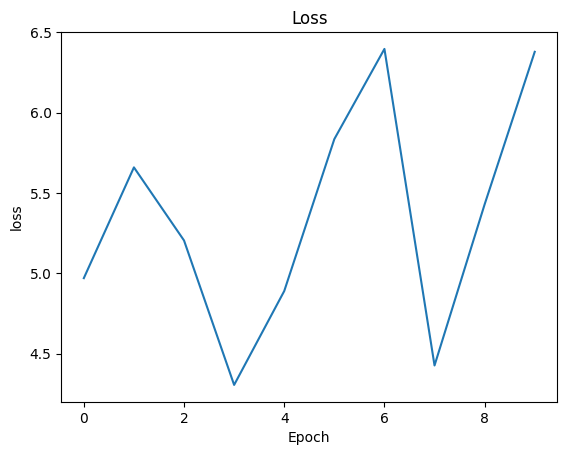

In [ ]:
plt.plot(L)
plt.title("Loss")
plt.xlabel('Epoch')
plt.ylabel("loss")

In [ ]:
output = model(data_x_ids)
output = torch.softmax(output, dim=-1)  # Chuẩn hóa đầu ra
predictions = torch.argmax(output, axis=-1)
accuracy = (sum(predictions == data_y_ids) / len(data_y_ids)) * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 5.02%


In [ ]:
def generate_text(model, start_seq, vocab, int_to_word, gen_length, temperature=1.0):
    model.eval()
    input_seq = [vocab[word] if word in vocab else vocab["<unk>"] for word in start_seq.split()]
    generated_text = start_seq

    for _ in range(gen_length):
        inputs = torch.tensor([input_seq], dtype=torch.long).to(device)
        output = model(inputs)  # Chỉ truyền input, không cần hidden state

        # Điều chỉnh nhiệt độ
        output = output / temperature
        probabilities = torch.softmax(output, dim=1).detach().cpu().numpy()

        # Chọn từ tiếp theo dựa trên phân phối xác suất
        next_word_idx = np.random.choice(len(probabilities[0]), p=probabilities[0])
        next_word = int_to_word[next_word_idx]

        # Thêm từ vào văn bản sinh ra
        generated_text += " " + next_word

        # Cập nhật dãy đầu vào (chỉ giữ lại các từ gần nhất)
        input_seq.append(next_word_idx)
        input_seq = input_seq[1:]

    return generated_text


In [ ]:
generated_text = generate_text(model, start_seq="Ăn quả nhớ", vocab=vocab, int_to_word=int_to_word, gen_length=7)
print(generated_text)

Ăn quả nhớ kim công phép đi kim cư có
